In [66]:
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

In [67]:
X = datasets.fetch_covtype().data[:3000]
y = datasets.fetch_covtype().target[:3000]
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_va, y_train, y_va = train_test_split(X_1, y_1)

print(X_train.shape, y_train.shape)
print(np.unique(y_train))  # 7分类任务

(2025, 54) (2025,)
[1 2 3 4 5 6 7]


In [68]:
enc = OrdinalEncoder()
y_train_enc = enc.fit_transform(y_train.reshape(-1, 1))
y_test_enc = enc.transform(y_test.reshape(-1, 1))
y_va_enc = enc.fit_transform(y_va.reshape(-1, 1))
print(np.unique(y_train_enc))
print(y_train_enc.shape)

[0. 1. 2. 3. 4. 5. 6.]
(2025, 1)


In [69]:
# 标签格式要求:label.shape = (num_sample, 1)
train_dataset = xgb.DMatrix(data=X_train, label=y_train_enc)
val_dataset = xgb.DMatrix(data=X_va, label=y_va_enc)
test_dataset = xgb.DMatrix(data=X_test)

In [70]:
params = {'objective': 'multi:softmax',
          "eval_metric": 'mlogloss',
          "verbosity": 0,
          "max_depth": 3,
          'num_class': 7}

# train_dataset的名称为train_,val_dataset的名称定义为val_
eval_set = [(train_dataset, "train_"), (val_dataset, "val_")]
evals_result = {}  # 储存评估指标(内置和自定义)结果

In [71]:
from sklearn.metrics import log_loss


def my_xgb_loss(y_pred, y_true):
    """xgboost自定义验证数据集损失函数格式"""
    loss = log_loss(y_true.get_label(), y_pred)
    return 'MY_GBM_LOSS', loss

In [72]:
model = xgb.train(params=params,
                  dtrain=train_dataset,
                  # num_boost_round (int) – Number of boosting iterations.
                  # 默认num_boost_round=10
                  num_boost_round=200,
                  # List of validation sets for which metrics will evaluated during training.
                  evals=eval_set,
                  early_stopping_rounds=100,
                  # verbose_eval (bool or int) – Requires at least one item in evals.
                  # If verbose_eval is True then the evaluation metric on the validation set is printed at each boosting stage.
                  # If verbose_eval is an integer then the evaluation metric on the validation set is printed at every given verbose_eval boosting stage.
                  # The last boosting stage / the boosting stage found by using
                  verbose_eval=20,  # 默认verbose_eval=True
                  evals_result=evals_result,
                  feval=my_xgb_loss,
                  )

[0]	train_-mlogloss:1.50301	train_-MY_GBM_LOSS:1.37300	val_-mlogloss:1.52248	val_-MY_GBM_LOSS:1.40228
[20]	train_-mlogloss:0.42090	train_-MY_GBM_LOSS:0.74937	val_-mlogloss:0.54136	val_-MY_GBM_LOSS:1.14210
[40]	train_-mlogloss:0.28880	train_-MY_GBM_LOSS:0.60300	val_-mlogloss:0.47181	val_-MY_GBM_LOSS:1.12613
[60]	train_-mlogloss:0.22168	train_-MY_GBM_LOSS:0.55916	val_-mlogloss:0.45836	val_-MY_GBM_LOSS:1.57441
[80]	train_-mlogloss:0.17178	train_-MY_GBM_LOSS:0.49661	val_-mlogloss:0.44062	val_-MY_GBM_LOSS:1.54414
[100]	train_-mlogloss:0.13673	train_-MY_GBM_LOSS:0.45855	val_-mlogloss:0.42927	val_-MY_GBM_LOSS:1.46680
[102]	train_-mlogloss:0.13370	train_-MY_GBM_LOSS:0.45466	val_-mlogloss:0.42765	val_-MY_GBM_LOSS:1.46217


In [73]:
# 预测结果为概率向量(多分类)
# test_dataset:The dmatrix storing the input
model.predict(test_dataset).shape

(300,)

In [74]:
evals_result

{'train_': OrderedDict([('mlogloss',
               [1.503009,
                1.251437,
                1.087687,
                0.968982,
                0.866905,
                0.796426,
                0.736344,
                0.688435,
                0.646976,
                0.609742,
                0.580633,
                0.552472,
                0.532816,
                0.510992,
                0.491823,
                0.476475,
                0.462055,
                0.449604,
                0.439608,
                0.428629,
                0.420898,
                0.411746,
                0.400924,
                0.391963,
                0.38417,
                0.375829,
                0.370084,
                0.363102,
                0.356112,
                0.348809,
                0.34321,
                0.3368,
                0.331415,
                0.326187,
                0.320882,
                0.315857,
                0.308966,
     

In [75]:
evals_result['train_'].keys()

odict_keys(['mlogloss', 'MY_GBM_LOSS'])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

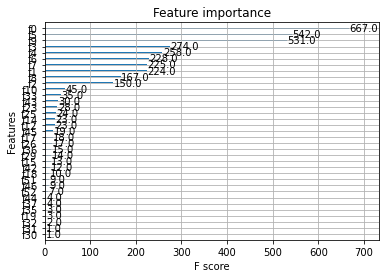

In [76]:
# 绘制特征的相对重要性
xgb.plot_importance(model)

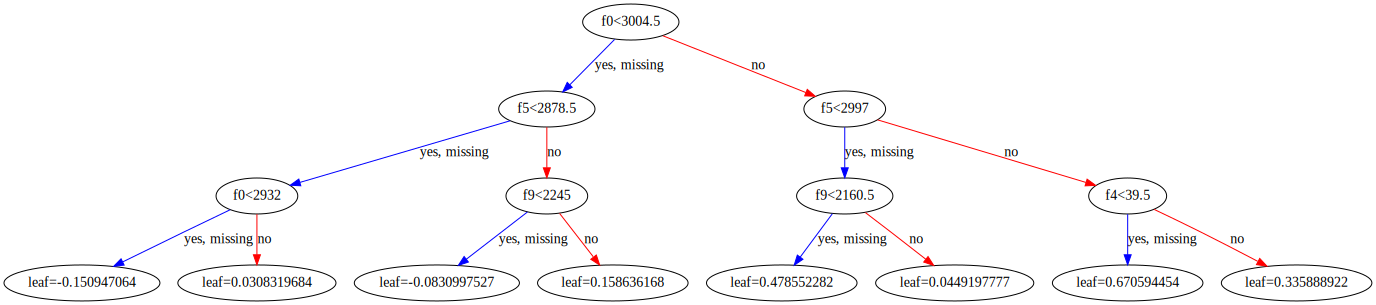

In [77]:
# 可视化lgb分割过程
img = xgb.to_graphviz(model,
                      # 目标函数是所有树的预测值相加等于预测值
                      num_trees=0)
# leaf=-0.15269695
# leaf=0.056757
# leaf=-0.125725
# leaf=-0.160423
# ......
# 表示xgboost论文中的$ \mathcal{L}_split $(决定特征的最佳分裂点)
img

In [78]:
# 数据类型graphviz.files.Source
type(img)

graphviz.sources.Source

In [79]:
# Parse a boosted tree model text dump into a pandas DataFrame structure.
# This feature is only defined when the decision tree model is chosen as base learner (booster in {gbtree, dart}).
df = model.trees_to_dataframe()
df.head()

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,f0,3004.5,0-1,0-2,0-1,304.968781,495.918396,NaN
1,0,1,0-1,f5,2878.5,0-3,0-4,0-3,32.896564,377.387787,NaN
2,0,2,0-2,f5,2997.0,0-5,0-6,0-5,43.799103,118.530624,NaN
3,0,3,0-3,f0,2932.0,0-7,0-8,0-7,4.176102,304.653076,NaN
4,0,4,0-4,f9,2245.0,0-9,0-10,0-9,10.679663,72.734695,NaN


In [80]:
# 决策路径
df[df['Tree'] == 0]

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,f0,3004.5,0-1,0-2,0-1,304.968781,495.918396,NaN
1,0,1,0-1,f5,2878.5,0-3,0-4,0-3,32.896564,377.387787,NaN
2,0,2,0-2,f5,2997.0,0-5,0-6,0-5,43.799103,118.530624,NaN
3,0,3,0-3,f0,2932.0,0-7,0-8,0-7,4.176102,304.653076,NaN
4,0,4,0-4,f9,2245.0,0-9,0-10,0-9,10.679663,72.734695,NaN
5,0,5,0-5,f9,2160.5,0-11,0-12,0-11,12.149552,32.326534,NaN
6,0,6,0-6,f4,39.5,0-13,0-14,0-13,21.537933,86.204086,NaN
7,0,7,0-7,Leaf,NaN,NaN,NaN,NaN,-0.150947,293.142883,NaN
8,0,8,0-8,Leaf,NaN,NaN,NaN,NaN,0.030832,11.510205,NaN
9,0,9,0-9,Leaf,NaN,NaN,NaN,NaN,-0.083100,23.755104,NaN
